In [2]:
# Deep Learning Libraries
# !pip install 'torch==2.0.1+cu117' -f https://download.pytorch.org/whl/torch_stable.html
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as data

# Data Manipulation and Analysis
import numpy as np
import pandas as pd
import collections # A module providing alternative data structures like named tuples, defaultdict, Counter, etc., compared to built-in Python containers.
import random

# Data Visualization
import matplotlib
import matplotlib.pyplot as plt
import seaborn

# File and System Interaction
import glob
import os
from pathlib import Path
import shutil

# Scientific Computing and Math
import scipy
from scipy.signal import tukey # A function from SciPy used to generate a Tukey window for signal processing.
from scipy.io import loadmat # A function from SciPy used for reading MATLAB data files.
import scipy.io as sio # The SciPy I/O module providing functions for working with different file formats.
import math
import cmath

# # Google Colab and Mount Drive
# from google.colab import drive
# drive.mount('/content/drive')

# Date and Time Handling
import time
import datetime

# Linear Algebra
from torch import linalg as LA
import importlib
import sys

In [3]:
from image_py_scripts import convmc, dataset_processing, logs_and_results, training

In [4]:
# Setting up some global variables

# ROOT = '/home/gcf/Desktop/Talha_Nehal Sproj/Tahir Sproj Stuff/SPROJ_ConvMC_Net/Sensor_Data'
ROOT = 'C:/Users/Talha/OneDrive - Higher Education Commission/Documents/GitHub/convmc-net/'
DATA_PATH = ROOT + '/Image_Inpainting_Dataset'
TRY = '1st_try'
SESSION = 'Session_1'

sys.path.append(ROOT + 'image_py_scripts')

In [5]:
# importlib.reload(convmc)
importlib.reload(training)
# importlib.reload(logs_and_results)
# importlib.reload(dataset_processing)

<module 'image_py_scripts.training' from 'c:\\Users\\Talha\\OneDrive - Higher Education Commission\\Documents\\GitHub\\convmc-net\\image_py_scripts\\training.py'>

Testing Training Loop

In [6]:
# Get parameters
def get_default_param(hyper_param_net, gpu = True):
    params_net = {}
    if hyper_param_net['Model'] == 'ADMM-Net':
        params_net['layers'] = 5

        params_net['initial_neta'] = 1.81    # fixed
        params_net['initial_lamda1'] = 0.051 # fixed
        params_net['initial_lamda2'] = 0.049 # fixed
        params_net['initial_v'] = 0

        params_net['initial_S'] = 0.05001 #fixed

        params_net['initial_P'] = 0.2401 #fixed

        params_net['initial_rho'] = 0.1001

        params_net['coef_gamma'] = 0.4001

        params_net['CalInGPU'] = gpu #whether to calculate in GPU
        params_net['size1'] = 49
        params_net['size2'] = 60

    else:
        params_net['layers'] = 5 #1 #2 #3 #4 #5 #6 #7 #8 #9 #10
        params_net['kernel'] = [(3, 1)] * 3 + [(3, 1)] * 7
        params_net['initial_mu_inverse'] = 0.0

        params_net['initial_y1']= 0.8

        params_net['coef_mu_inverse'] = 0.36

        params_net['CalInGPU'] = gpu # whether to calculate in GPU
        params_net['kernel'] = params_net['kernel'][0:params_net['layers']]
        params_net['rank'] = 10
        params_net['size1'] = 150
        params_net['size2'] = 300

    return params_net

Project Name: ConvMC-Net_Sampling20.0%_GMM5.0
Configuring Network...

Instantiating Model...

Model Instantiated...

Model Configured...

Parameters = 
{'layers': 5, 'kernel': [(3, 1), (3, 1), (3, 1), (3, 1), (3, 1)], 'initial_mu_inverse': 0.0, 'initial_y1': 0.8, 'coef_mu_inverse': 0.36, 'CalInGPU': False, 'rank': 10, 'size1': 150, 'size2': 300}

Loading Data phase...
----------------
Finished loading.



c:\Users\Talha\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch: 1, 2024-04-30 05:02:43, 

Epoch: 2, 2024-04-30 05:02:46, 

Epoch: 3, 2024-04-30 05:02:49, 

Epoch: 4, 2024-04-30 05:02:52, 

Epoch: 5, 2024-04-30 05:02:55, 

Loading and calculating training batches...
Training time is 2.253424
Loading and calculating validation batches...
Test time is 0.489151
Epoch: 6, 2024-04-30 05:02:58, 

Epoch: 7, 2024-04-30 05:03:00, 

Epoch: 8, 2024-04-30 05:03:03, 

Epoch: 9, 2024-04-30 05:03:07, 

Epoch: 10, 2024-04-30 05:03:09, 

Loading and calculating training batches...
Training time is 3.198622
Loading and calculating validation batches...
Test time is 0.488715
Epoch: 11, 2024-04-30 05:03:13, 

Epoch: 12, 2024-04-30 05:03:16, 

Epoch: 13, 2024-04-30 05:03:19, 

Epoch: 14, 2024-04-30 05:03:21, 

Epoch: 15, 2024-04-30 05:03:24, 

Loading and calculating training batches...
Training time is 2.107177
Loading and calculating validation batches...
Test time is 0.447314
Epoch: 16, 2024-04-30 05:03:26, 

Epoch: 17, 2024-04-30 05:03:29, 

Epoch: 18, 2024-0

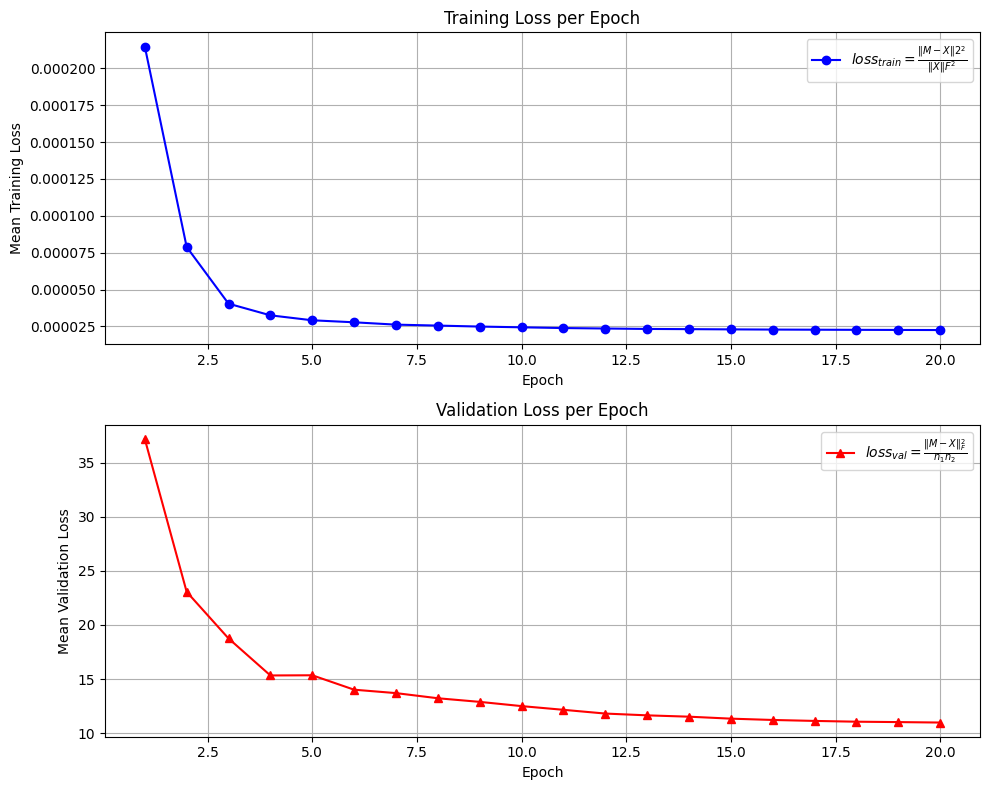


min Loss = 1.0986e+01
Project Name: ConvMC-Net_Sampling30.0%_GMM5.0
Configuring Network...

Instantiating Model...

Model Instantiated...

Model Configured...

Parameters = 
{'layers': 5, 'kernel': [(3, 1), (3, 1), (3, 1), (3, 1), (3, 1)], 'initial_mu_inverse': 0.0, 'initial_y1': 0.8, 'coef_mu_inverse': 0.36, 'CalInGPU': False, 'rank': 10, 'size1': 150, 'size2': 300}

Loading Data phase...
----------------
Finished loading.

Epoch: 1, 2024-04-30 05:03:42, 

Epoch: 2, 2024-04-30 05:03:46, 

Epoch: 3, 2024-04-30 05:03:49, 

Epoch: 4, 2024-04-30 05:03:52, 

Epoch: 5, 2024-04-30 05:03:55, 

Loading and calculating training batches...
Training time is 2.798302
Loading and calculating validation batches...
Test time is 0.477745
Epoch: 6, 2024-04-30 05:03:58, 

Epoch: 7, 2024-04-30 05:04:01, 

Epoch: 8, 2024-04-30 05:04:04, 

Epoch: 9, 2024-04-30 05:04:08, 

Epoch: 10, 2024-04-30 05:04:11, 

Loading and calculating training batches...
Training time is 2.939242
Loading and calculating validat

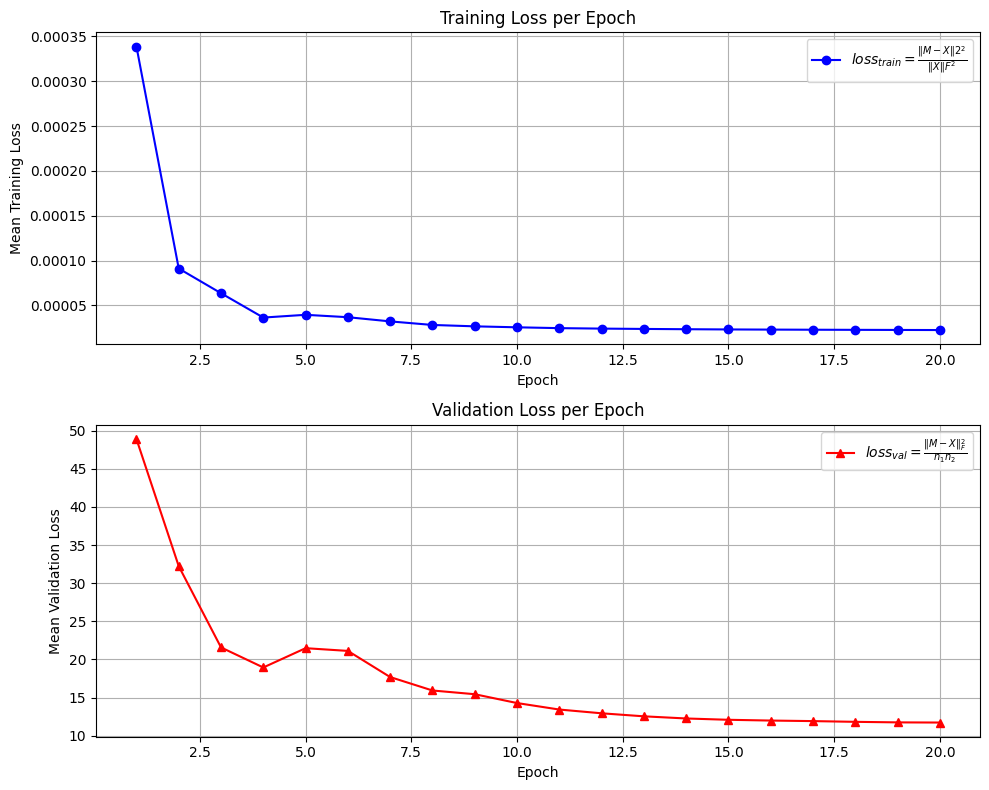


min Loss = 1.1730e+01
Project Name: ConvMC-Net_Sampling40.0%_GMM5.0
Configuring Network...

Instantiating Model...

Model Instantiated...

Model Configured...

Parameters = 
{'layers': 5, 'kernel': [(3, 1), (3, 1), (3, 1), (3, 1), (3, 1)], 'initial_mu_inverse': 0.0, 'initial_y1': 0.8, 'coef_mu_inverse': 0.36, 'CalInGPU': False, 'rank': 10, 'size1': 150, 'size2': 300}

Loading Data phase...
----------------
Finished loading.

Epoch: 1, 2024-04-30 05:04:45, 

Epoch: 2, 2024-04-30 05:04:49, 

Epoch: 3, 2024-04-30 05:04:52, 

Epoch: 4, 2024-04-30 05:04:55, 

Epoch: 5, 2024-04-30 05:04:58, 

Loading and calculating training batches...
Training time is 3.509324
Loading and calculating validation batches...
Test time is 0.709461
Epoch: 6, 2024-04-30 05:05:02, 

Epoch: 7, 2024-04-30 05:05:06, 

Epoch: 8, 2024-04-30 05:05:09, 

Epoch: 9, 2024-04-30 05:05:13, 

Epoch: 10, 2024-04-30 05:05:15, 

Loading and calculating training batches...
Training time is 2.345930
Loading and calculating validat

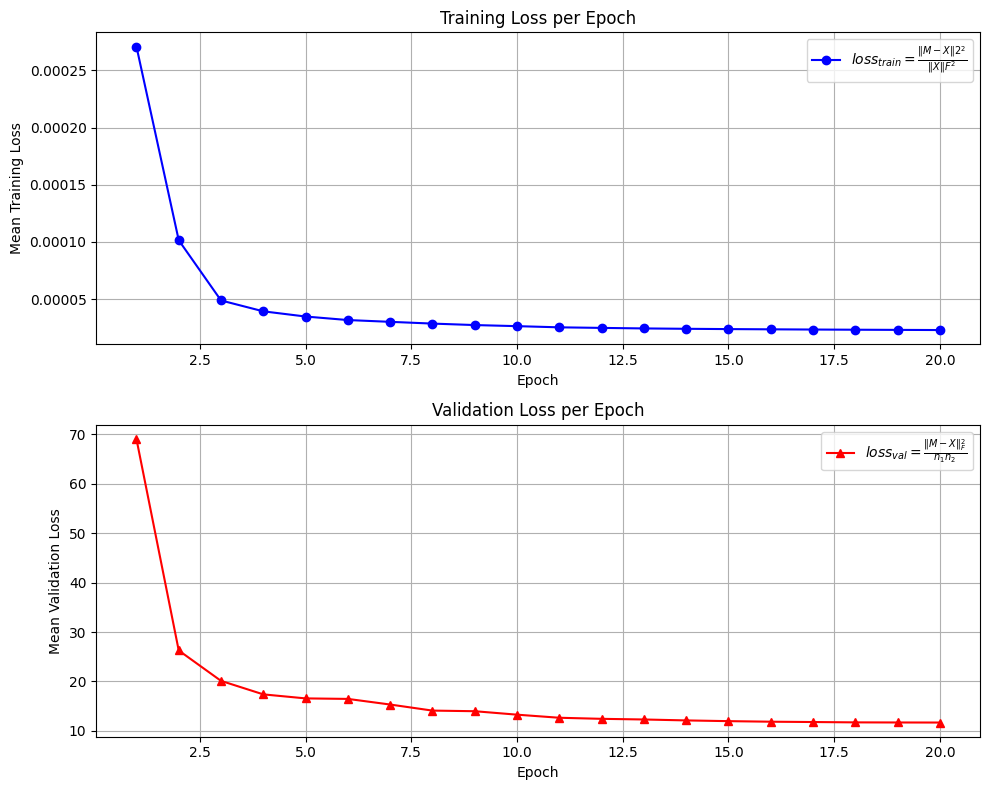


min Loss = 1.1684e+01
Project Name: ConvMC-Net_Sampling50.0%_GMM5.0
Configuring Network...

Instantiating Model...

Model Instantiated...

Model Configured...

Parameters = 
{'layers': 5, 'kernel': [(3, 1), (3, 1), (3, 1), (3, 1), (3, 1)], 'initial_mu_inverse': 0.0, 'initial_y1': 0.8, 'coef_mu_inverse': 0.36, 'CalInGPU': False, 'rank': 10, 'size1': 150, 'size2': 300}

Loading Data phase...
----------------
Finished loading.

Epoch: 1, 2024-04-30 05:05:51, 

Epoch: 2, 2024-04-30 05:05:54, 

Epoch: 3, 2024-04-30 05:05:57, 

Epoch: 4, 2024-04-30 05:06:03, 

Epoch: 5, 2024-04-30 05:06:08, 

Loading and calculating training batches...
Training time is 5.475188
Loading and calculating validation batches...
Test time is 0.812629
Epoch: 6, 2024-04-30 05:06:15, 

Epoch: 7, 2024-04-30 05:06:22, 

Epoch: 8, 2024-04-30 05:06:28, 

Epoch: 9, 2024-04-30 05:06:33, 

Epoch: 10, 2024-04-30 05:06:37, 

Loading and calculating training batches...
Training time is 3.101315
Loading and calculating validat

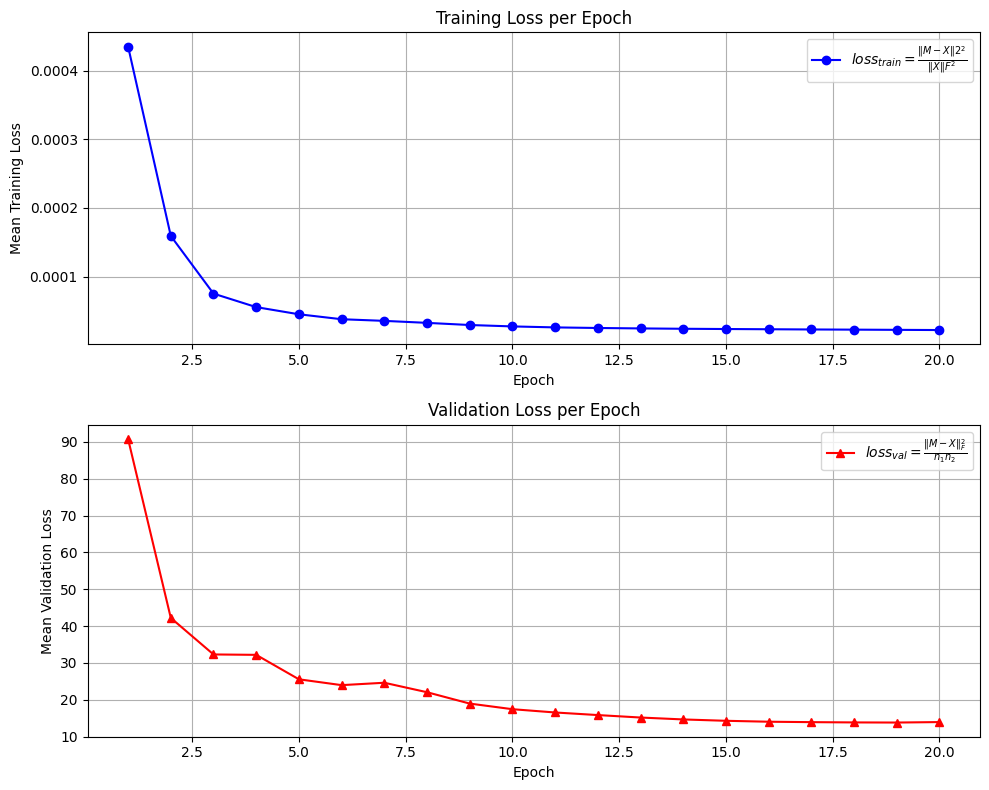


min Loss = 1.3817e+01
Project Name: ConvMC-Net_Sampling60.0%_GMM5.0
Configuring Network...

Instantiating Model...

Model Instantiated...

Model Configured...

Parameters = 
{'layers': 5, 'kernel': [(3, 1), (3, 1), (3, 1), (3, 1), (3, 1)], 'initial_mu_inverse': 0.0, 'initial_y1': 0.8, 'coef_mu_inverse': 0.36, 'CalInGPU': False, 'rank': 10, 'size1': 150, 'size2': 300}

Loading Data phase...
----------------
Finished loading.

Epoch: 1, 2024-04-30 05:07:24, 

Epoch: 2, 2024-04-30 05:07:28, 

Epoch: 3, 2024-04-30 05:07:31, 

Epoch: 4, 2024-04-30 05:07:34, 

Epoch: 5, 2024-04-30 05:07:37, 

Loading and calculating training batches...
Training time is 3.931207
Loading and calculating validation batches...
Test time is 0.561571
Epoch: 6, 2024-04-30 05:07:41, 

Epoch: 7, 2024-04-30 05:07:45, 

Epoch: 8, 2024-04-30 05:07:49, 

Epoch: 9, 2024-04-30 05:07:53, 

Epoch: 10, 2024-04-30 05:07:57, 

Loading and calculating training batches...
Training time is 4.210023
Loading and calculating validat

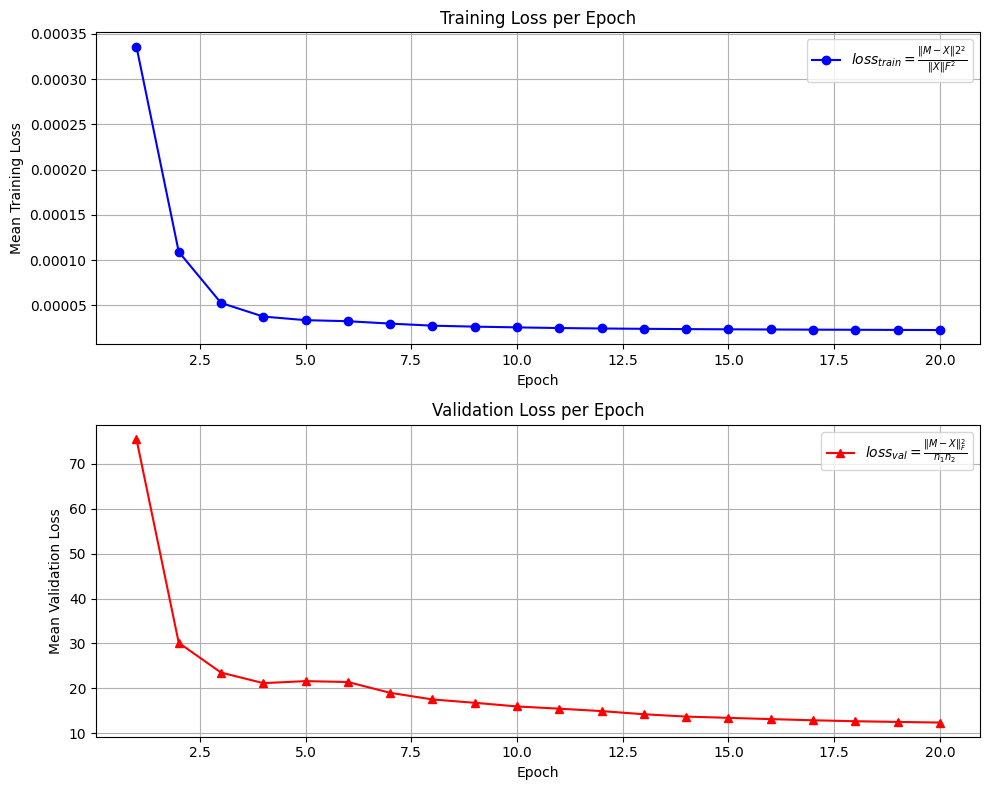


min Loss = 1.2379e+01
Project Name: ConvMC-Net_Sampling70.0%_GMM5.0
Configuring Network...

Instantiating Model...

Model Instantiated...

Model Configured...

Parameters = 
{'layers': 5, 'kernel': [(3, 1), (3, 1), (3, 1), (3, 1), (3, 1)], 'initial_mu_inverse': 0.0, 'initial_y1': 0.8, 'coef_mu_inverse': 0.36, 'CalInGPU': False, 'rank': 10, 'size1': 150, 'size2': 300}

Loading Data phase...
----------------
Finished loading.

Epoch: 1, 2024-04-30 05:08:51, 

Epoch: 2, 2024-04-30 05:08:54, 

Epoch: 3, 2024-04-30 05:08:59, 

Epoch: 4, 2024-04-30 05:09:04, 

Epoch: 5, 2024-04-30 05:09:07, 

Loading and calculating training batches...
Training time is 3.617074
Loading and calculating validation batches...
Test time is 0.451801
Epoch: 6, 2024-04-30 05:09:11, 

Epoch: 7, 2024-04-30 05:09:15, 

Epoch: 8, 2024-04-30 05:09:20, 

Epoch: 9, 2024-04-30 05:09:25, 

Epoch: 10, 2024-04-30 05:09:29, 

Loading and calculating training batches...
Training time is 2.374729
Loading and calculating validat

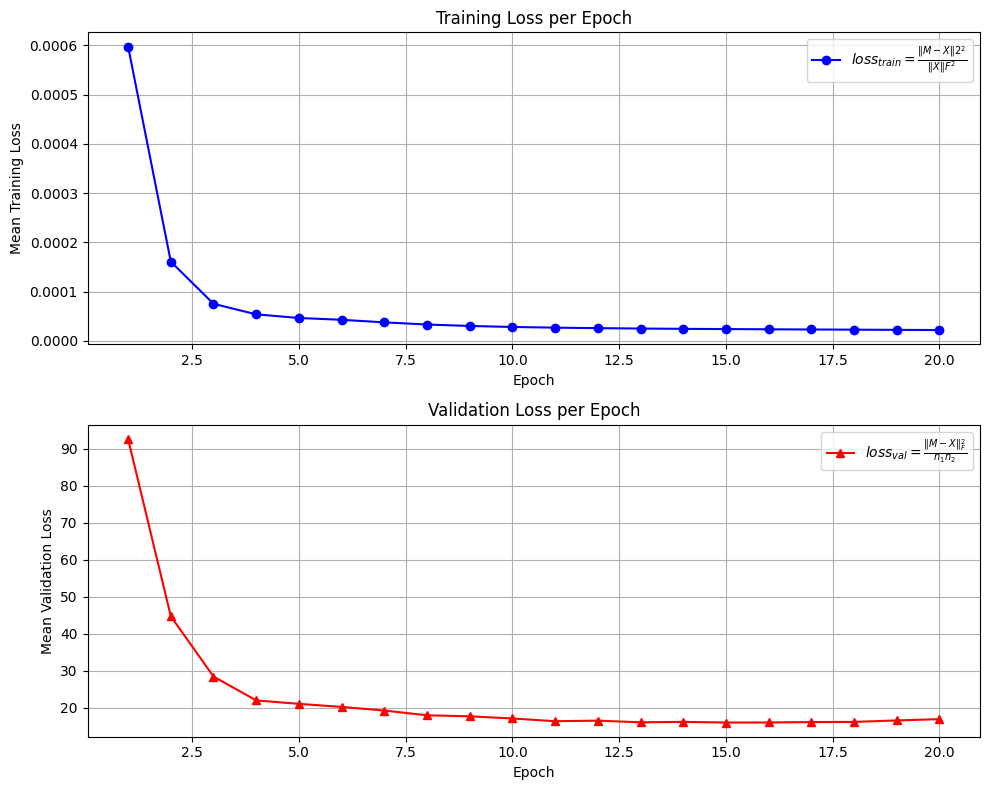


min Loss = 1.6025e+01
Project Name: ConvMC-Net_Sampling80.0%_GMM5.0
Configuring Network...

Instantiating Model...

Model Instantiated...

Model Configured...

Parameters = 
{'layers': 5, 'kernel': [(3, 1), (3, 1), (3, 1), (3, 1), (3, 1)], 'initial_mu_inverse': 0.0, 'initial_y1': 0.8, 'coef_mu_inverse': 0.36, 'CalInGPU': False, 'rank': 10, 'size1': 150, 'size2': 300}

Loading Data phase...
----------------
Finished loading.

Epoch: 1, 2024-04-30 05:10:22, 

Epoch: 2, 2024-04-30 05:10:28, 

Epoch: 3, 2024-04-30 05:10:35, 

Epoch: 4, 2024-04-30 05:10:41, 

Epoch: 5, 2024-04-30 05:10:46, 

Loading and calculating training batches...
Training time is 3.551366
Loading and calculating validation batches...
Test time is 1.077586
Epoch: 6, 2024-04-30 05:10:51, 

Epoch: 7, 2024-04-30 05:10:56, 

Epoch: 8, 2024-04-30 05:11:01, 

Epoch: 9, 2024-04-30 05:11:07, 

Epoch: 10, 2024-04-30 05:11:12, 

Loading and calculating training batches...
Training time is 4.990833
Loading and calculating validat

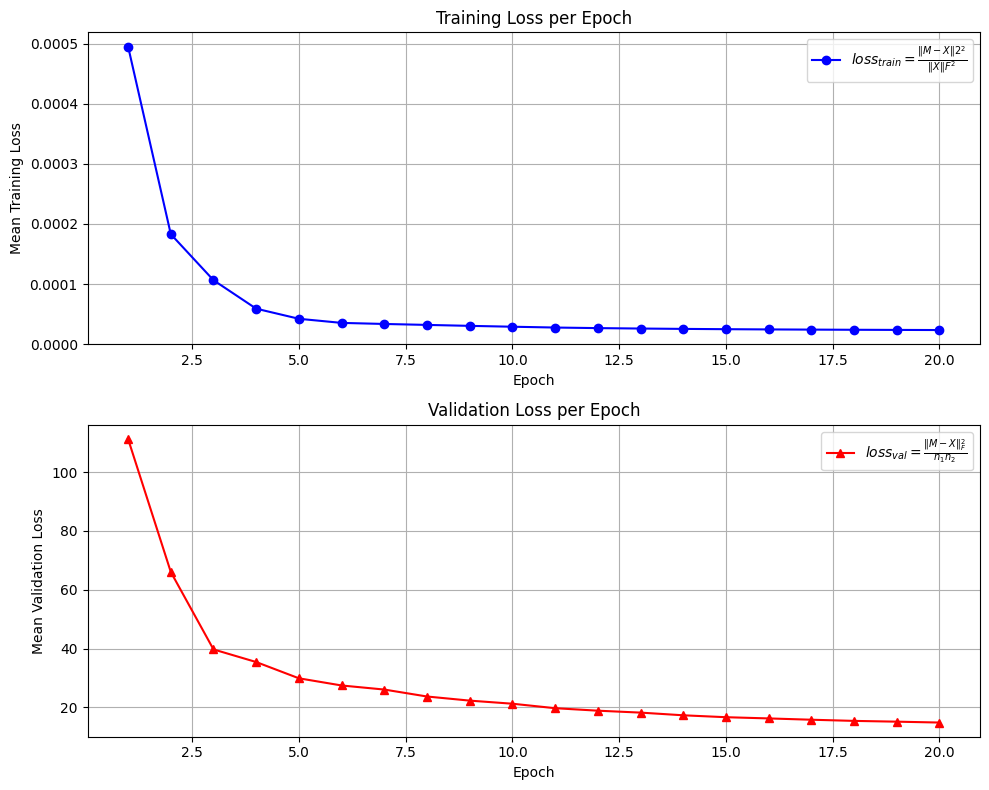


min Loss = 1.4884e+01


In [7]:
# Some settings for visualisation
matplotlib.use('Agg')
%matplotlib inline

seed = 123
torch.manual_seed(seed)

# Set parameters (including hyperparameters) and setting for saving/logging data

hyper_param_net = training.get_hyperparameter_grid('ConvMC-Net', TrainInstances = 20, ValInstances = 10, BatchSize = 5, ValBatchSize = 2, num_epochs = 20, learning_rate = 0.12)

params_net = get_default_param(hyper_param_net, False)

CalInGPU = params_net['CalInGPU']

q_list = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
db_list = [5.0]

for q in q_list:
  for db in db_list:
    ProjectName = hyper_param_net['Model'] + '_' + 'Sampling' + logs_and_results.get_q_str(q) + '_GMM' + logs_and_results.get_noise_str(db)

    # Get log file
    logfile = logs_and_results.get_modularized_record(ProjectName, q, db, 'Logs', hyper_param_net, params_net, DATA_PATH, SESSION)
    log = open(logfile, 'w')
    print('Project Name: %s'%ProjectName)
    log.write('Project Name: %s\n'%ProjectName)

    # Get Model
    net = training.get_model(params_net, hyper_param_net, log)
    print('Parameters = \n%s\n'%str(params_net))
    log.write('params_net=\n%s\n\n'%str(params_net))

    #Loading data and creating dataloader for both test and training
    print('Loading Data phase...')
    print('----------------')
    log.write('Loading phase...\n')
    log.write('----------------\n')
    shape_dset = (params_net['size1'], params_net['size2'])
    
    train_loader, val_loader = dataset_processing.get_dataloaders(params_net = params_net, hyper_param_net = hyper_param_net, sampling_rate = q, db = db, ROOT = DATA_PATH)

    print('Finished loading.\n')
    log.write('Finished loading.\n\n');

    # Some additional settings for training including loss, optimizer,
    floss = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr = hyper_param_net['Lr'])
    scheduler2 =  torch.optim.lr_scheduler.StepLR(optimizer, step_size = 1, gamma = 0.97, verbose = True)

    # Array for recording parameter values after each layer for each epoch etc
    outputs_L = convmc.to_var(torch.zeros([shape_dset[0], shape_dset[1]]), CalInGPU)
    lossmean_vec = np.zeros((hyper_param_net['Epochs'], ))
    lossmean_val_vec = np.zeros((hyper_param_net['Epochs'], ))

    mu_inverse, y1, exp_L = net.getexp_LS()

    mu_inverse_vec = np.zeros((hyper_param_net['Epochs'], net.layers))
    y1_vec = np.zeros((hyper_param_net['Epochs'], net.layers,params_net['size1'], params_net['size2']))
    exp_L_vec = np.zeros((hyper_param_net['Epochs'], net.layers))

    # dummy variable to monitor and record progress for loss
    minloss = np.inf

    for epoch in range(hyper_param_net['Epochs']):
      print(f'Epoch: {epoch + 1}, {logs_and_results.get_current_time()}, \n')
      log.write('\n' + logs_and_results.get_current_time() + '\n')

      # Train and Test Steps. (Record every 5 epochs)
      if (epoch + 1) % 5 == 0:
          print('Loading and calculating training batches...')
          log.write('Loading and calculating training batches...\n')
          startime = time.time()
          loss_mean = training.train_step(net, train_loader, floss, optimizer, CalInGPU, hyper_param_net['TrainInstances'], hyper_param_net['BatchSize'])
          endtime = time.time()
          print('Training time is %f'%(endtime - startime))
          log.write('Training time is %f\n'%(endtime - startime))

          print('Loading and calculating validation batches...')
          log.write('Loading and calculating validation batches...\n')
          startime = time.time()
          loss_val_mean = training.test_step(net, val_loader, floss, CalInGPU, hyper_param_net['ValInstances'], hyper_param_net['ValBatchSize'])
          endtime = time.time()
          print('Test time is %f'%(endtime - startime))
          log.write('Test time is %f\n'%(endtime - startime))
      else:
        loss_mean = training.train_step(net, train_loader, floss, optimizer, CalInGPU, hyper_param_net['TrainInstances'], hyper_param_net['BatchSize'])
        loss_val_mean = training.test_step(net, val_loader, floss, CalInGPU, hyper_param_net['ValInstances'], hyper_param_net['ValBatchSize'])

      # Update Record and Parameters
      lossmean_vec[epoch] = loss_mean
      lossmean_val_vec[epoch] = loss_val_mean

      mu_inverse, y1, exp_L = net.getexp_LS()

      mu_inverse_vec[epoch, :] = mu_inverse
      y1_vec[epoch] = y1
      exp_L_vec[epoch, :] = exp_L

      # Update Log after every 5 epochs. Make a plot of MSE against epochs every 5 epochs. Save Model in whole/dict form every five epochs.
      if (epoch + 1) % 20 == 0:
        print(f"Saving Whole Model at Epochs: [{epoch + 1}/{hyper_param_net['Epochs']}]")
        model_whole_path = logs_and_results.get_modularized_record(ProjectName, q, db, 'Saved Models - Whole', hyper_param_net, params_net, DATA_PATH, SESSION, current_epoch = epoch + 1)
        torch.save(net, model_whole_path)
        print(f"Saving Model Dict at Epochs: [{epoch + 1}/{hyper_param_net['Epochs']}]")
        model_state_dict_path = logs_and_results.get_modularized_record(ProjectName, q, db, 'Saved Models - Dict', hyper_param_net, params_net, DATA_PATH, SESSION, current_epoch = epoch + 1)
        torch.save(net.state_dict(), model_state_dict_path)

        print('Epoch [%d/%d], Lossmean:%.5e, Validation lossmean:%.5e'
              %(epoch + 1, hyper_param_net['Epochs'], loss_mean, loss_val_mean))
        log.write('Epoch [%d/%d], Lossmean:%.5e, Validation lossmean:%.5e\n'
              %(epoch + 1, hyper_param_net['Epochs'], loss_mean, loss_val_mean))
        np.set_printoptions(precision = 3)

        print('mu_inverse:', mu_inverse)

        print('torch.mean(y1)', np.mean(y1))
        print('y1:', y1)
        print('exp_L:', exp_L)

        log.write('mu_inverse: '+ str(mu_inverse)+'\n')
        log.write('y1: '+ str(y1)+'\n')
        log.write('exp_L: '+ str(exp_L) + '\n')

        if True or loss_val_mean<minloss:
          print('saved at [epoch%d/%d]'%(epoch + 1, hyper_param_net['Epochs']))
          log.write('saved at [epoch%d/%d]\n' %(epoch + 1, hyper_param_net['Epochs']))
          minloss = min(loss_val_mean, minloss)

        # Plotting MSE vs Epoch and Saving it

        # Get Directory where we have to save the plot
        # dir = logs_and_results.get_modularized_record(ProjectName, q, db, 'Plots', hyper_param_net, params_net, SESSION, current_epoch = epoch + 1)
        # epochs_vec = np.arange(0, hyper_param_net['Epochs'], 1)
        # logs_and_results.plot_and_save_mse_vs_epoch(epochs_vec, lossmean_vec, hyper_param_net, lossmean_val_vec, dir, epoch)

        log.write('\nMin Loss = %.4e'%np.min(lossmean_val_vec)) # Plotting MSE vs Epoch and Saving it
        # Get Directory where we have to save the plot
        dir = logs_and_results.get_modularized_record(ProjectName, q, db, 'Plots', hyper_param_net, params_net, DATA_PATH, SESSION, current_epoch = epoch + 1)
        logs_and_results.plot_and_save_mse_vs_epoch(lossmean_vec, lossmean_val_vec, dir)

    # Finish off by observing the minimum loss on validation set

    #Print min loss
    print('\nmin Loss = %.4e'%np.min(lossmean_val_vec))
    log.write('\nmin Loss = %.4e\n'%np.min(lossmean_val_vec))
    log.close()